## **Quantum Computing for Option Pricing - Challenge Solution**

 ### Dependencies and imports 

We developed this solution within a conda environment (miniconda) running Python 3.11.2 and the following libraries: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.algorithms.optimizers import SPSA,COBYLA
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow import PauliSumOp
from qiskit.algorithms import TimeEvolutionProblem, VarQITE
from qiskit.algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit import ParameterVector
from matplotlib import cm
import step1
import step2

### **Step 1**: Build the ansatz circuit and the hamiltonian

For simplicity, we'll use the proposed ansatz:

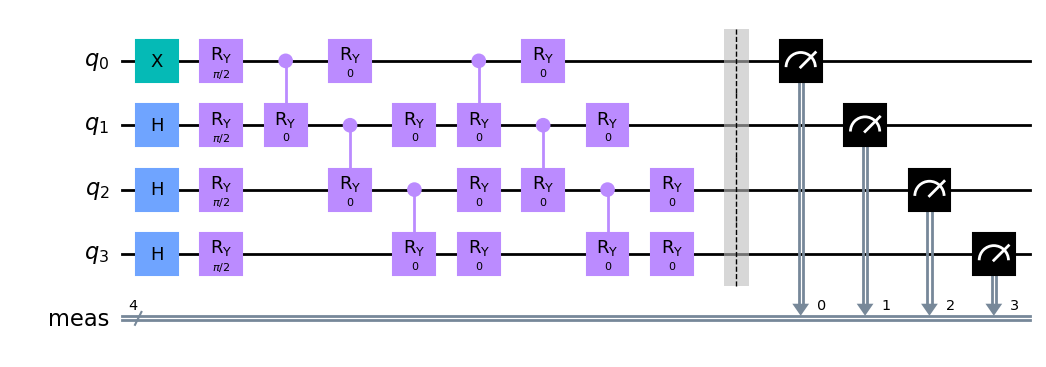

In [2]:
n_qbits=4
rep = 2

params = step1.get_init_params(n_qbits,rep)

qc = step1.ansatz(params,n_qbits,rep)
qc.measure_all()
display(qc.draw('mpl'))

In [3]:
K = 100 # strike price
sigma = 0.1 # volatility in %
T= 1
r = 0
Smin = 0
Smax = 150
n_qbits = 4
delta = (Smax - Smin)/(2**n_qbits-1) #price discretization

H = step1.hamiltonian(n_qbits, delta,  r, sigma)
print('Price step:',delta)
print(H)


Price step: 10.0
[[ 0.125  0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.005 -0.01   0.005  0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.005 -0.01   0.005  0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.005 -0.01   0.005  0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.005 -0.01   0.005  0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.005 -0.01   0.005  0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.005 -0.01   0.005  0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.005 -0.01   0.005  0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.005 -0.01   0.005

### **Step 2**: Build the initial state for the hybrid quantum-classical algorithm

In [4]:
K_quantum = 6 #Strike price when prices are represented by the computational basis

n_qbits = 4
rep = 2
params = step1.get_init_params(n_qbits,rep)

backend = Aer.get_backend('aer_simulator_statevector')


We need to define `cost_func(params)` within this notebook because `optimizer.minimize()` only admits functions with one argument. Therefore, if we want that `cost_func(params)` in sensitive to the number of qbits, the strike price and the backend machine it needs to be in the same file of these variables. Besides, we will define the rest of the functions here to provide full visibility of the most important part of the challenge.

In [5]:
def cost_func(params):
    """Compares the output distribution of our circuit with
    parameters `params` to the target distribution."""
    # Create circuit instance with paramters and simulate it
    qc = step1.ansatz(params, n_qbits, rep)
    qc.measure_all()
    qc_t = transpile(qc, backend)
    result = backend.run(qc_t).result()
    # Get the counts for each measured state, and convert those counts into a probability dict
    output_distr = step2.counts_to_distr(result.get_counts())
    # Calculate the cost as the distance between the output distribution and the target distribution
    cost = sum(
        abs(step2.create_target_distr(n_qbits, K_quantum).get(i, 0) - output_distr.get(i, 0))
        for i in range(2**n_qbits)
    )
    return cost

def plot_optimized_amplitudes(optimized_result):
    qc = step1.ansatz(optimized_result.x, n_qbits,rep)
    qc.measure_all()
    qc_t = transpile(qc,backend)


    final_result = backend.run(qc_t, shots=int(1e5)).result()
    counts = final_result.get_counts()

    output_distr = step2.counts_to_distr(counts)
    output_amplitudes = step2.get_sorted_amplitudes(output_distr)

    fig, ax = plt.subplots()
    ax.spines['bottom'].set_position('zero')
    ax.plot(output_amplitudes.keys(), output_amplitudes.values(), '--', color='g')
    plt.xlabel('S')
    plt.ylabel('Payoff')
    plt.title('European Call Option Payoff')
    plt.show()

### Optimization with SPSA

SPSA (Simultaneous Perturbation Stochastic Approximation) is a stochastic gradient descent method used for finding the optimal parameters of a function. It is well-suited for optimization problems that have noisy or uncertain gradients. SPSA uses a gradient estimate based on random perturbations of the input parameters, making it robust to noise in the function evaluation.

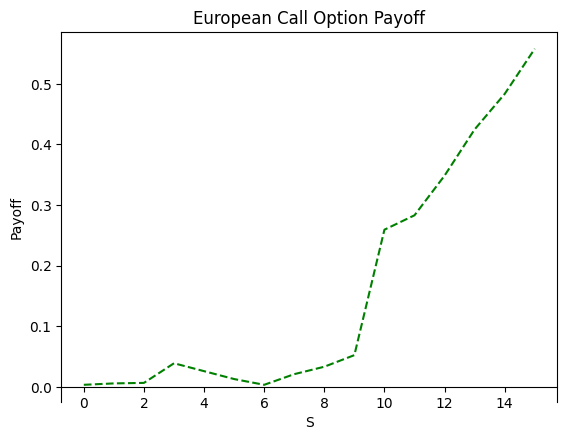

In [6]:
optimizer = SPSA(maxiter=1e3)
optimization_result = optimizer.minimize(fun=cost_func,x0=params)
plot_optimized_amplitudes(optimization_result)

### Optimization with COBYLA

COBYLA (Constrained Optimization BY Linear Approximation) is a derivative-free optimization method that is used for minimizing a function subject to constraints. COBYLA does not use gradient information and works by approximating the function with a linear model within a trust region of the input parameters.


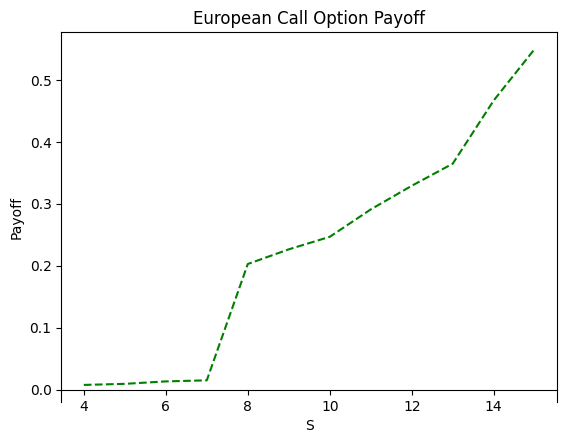

In [7]:
optimizer = COBYLA(maxiter=1e3, tol = 0.00001)
optimization_result = optimizer.minimize(fun=cost_func,x0=params)
plot_optimized_amplitudes(optimization_result)

Both SPSA and COBYLA are commonly used in quantum computing for optimizing quantum circuits, as the noisy and constrained nature of quantum systems can make traditional optimization methods impractical. However, in this case COBYLA seems to provide more reasonable values, so we'll move on with those.

### **Step 3**: Simulate the hybrid quantum-classical routine to price an European call option

Until now we were trying hard to avoid spaghetti code but it's being impossible to refactor the code while keeping the same results, sorry about that :)

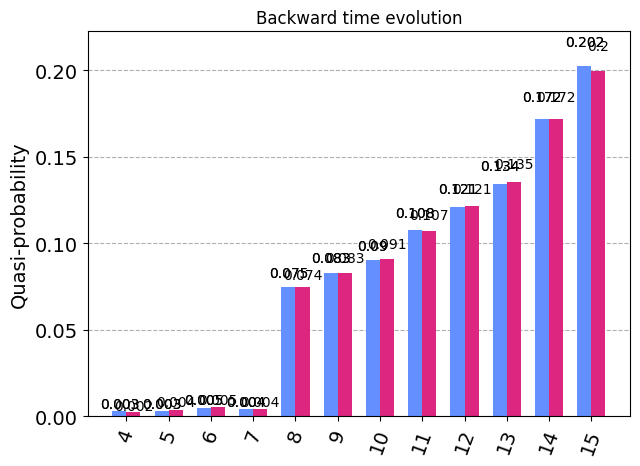

In [12]:
n_qubits=4
rep=2

H_fact = SparsePauliOp.from_operator(step1.hamiltonian(n_qbits, delta,  r, sigma))
pauli_op = PauliSumOp.from_list(H_fact.to_list())
param_vec = ParameterVector('θ', length=n_qubits + rep*(2*n_qubits-1))

observable = pauli_op

qc = step1.ansatz(optimization_result.x, n_qbits,rep)
qc.measure_all()
qc_t = transpile(qc,backend)

final_result = backend.run(qc_t, shots=int(1e5)).result()
counts = final_result.get_counts()

qc = step1.ansatz(param_vec, n_qubits=n_qubits, rep=rep)

time = 10

evolution_problem = TimeEvolutionProblem(observable, time=time*sigma**2)
var_qite = VarQITE(
    ansatz=qc,
    initial_parameters=optimization_result.x,
)
evolution_result = var_qite.evolve(evolution_problem)

qc = evolution_result.evolved_state
qc_t = transpile(qc, backend=backend)
params_step = evolution_result.parameter_values[-1]

qc = step1.ansatz(params=params_step, n_qubits=n_qubits, rep=rep)
qc.measure_all()
qc_t = transpile(qc, backend)
result_step = backend.run(qc_t, shots=int(1e5)).result()
counts_step = result_step.get_counts()
display(plot_histogram([step2.get_sorted_amplitudes(step2.counts_to_distr(counts)), 
                        step2.get_sorted_amplitudes(step2.counts_to_distr(counts_step))], 
                        title='Backward time evolution'))

/home/adria/Qiskit Hackathon/Qisikit_Hackathon_BCN/step1.py:26: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S0/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))


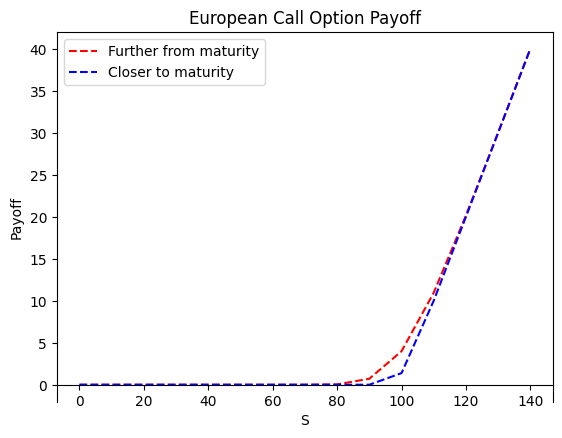

In [9]:
#Define range of stock price
K = 100 # strike price
sigma = 0.1 # volatility in %
r = 0
Smin = 0
Smax = 150
n_qbits = 4
delta = (Smax - Smin)/(2**n_qbits-1) #price discretization
S = np.arange(Smin,Smax,delta)

fig, ax = plt.subplots()
ax.spines['bottom'].set_position('zero')
t=1 #Note that t=0 means we are at maturity, we are moving backwards
ax.plot(S, step1.black_scholes_european_call_payoff(S, K, t, r, sigma), '--', color='red',label='Further from maturity')
t= 0.12 #Note that t=0 means we are at maturity, we are moving backwards
ax.plot(S, step1.black_scholes_european_call_payoff(S, K, t, r, sigma), '--', color = 'blue',label='Closer to maturity')
plt.xlabel('S')
plt.ylabel('Payoff')
plt.title('European Call Option Payoff')
plt.legend()
plt.show()

Note that our solution is consistent with the analytical solution of the Black-Scholes equation. Note that the red payoff is prior to the blue one, if time evolves forward.

### **Bonus points**:

- Run the hybrid quantum-classical on a QPU (optimize for given QPU connectivity). Reason whether you need state tomography, reason if possible to extract the information of interest (only the price call at the current date) with alternatives that require less expensive techniques. On a QPU or QASM  simulator, you only have access to short-estimated probabilities.

- Reason how to extend the algorithm to other type of options or to a multi-dimensional BS model.

In [10]:
amp = step2.counts_to_amp(counts)
time_evolve = np.array([amp[key] for key in sorted(amp)], ndmin=2)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (16, 11) and arg 2 with shape (1, 12).

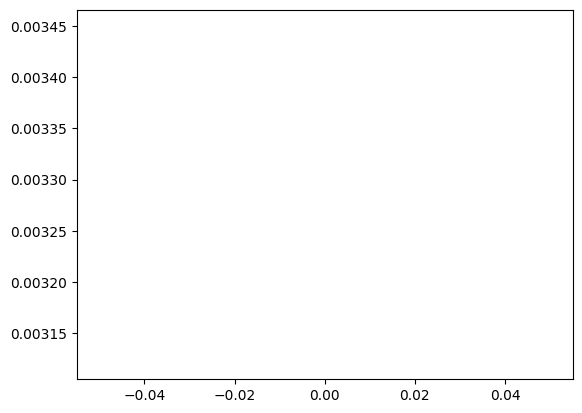

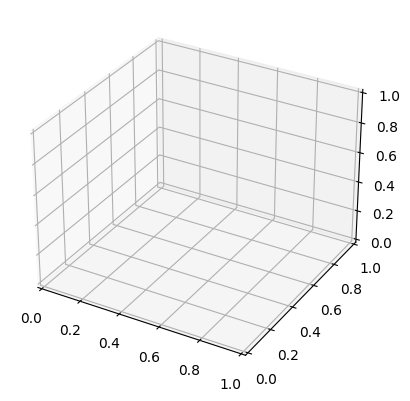

In [11]:
param_vec = ParameterVector('θ', length=n_qubits + rep*(2*n_qubits-1))

observable = pauli_op

qc = step1.ansatz(param_vec, n_qubits=n_qubits, rep=rep)

time = 5
num_step = 2
evolution_problem = TimeEvolutionProblem(observable, time=sigma**2*time)
var_qite = VarQITE(
    ansatz=qc,
    initial_parameters=optimization_result.x,
    num_timesteps=num_step*time,
)
evolution_result = var_qite.evolve(evolution_problem)


X = np.linspace(50, 150, 16)
Y = np.linspace(0, 5, time*num_step+1)
Y, X = np.meshgrid(Y, X)
plt.plot(time_evolve[:, 0])
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(Y, X, time_evolve, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plot_histogram(counts_to_amp(result_step.get_counts()))



- Implement Montecarlo or Finite differences schemes to solve the simple option pricing exercise. A classical baseline to compare with is useful. Argue where does the hybrid quantum algortihm stand in terms of error, runtime and numerical stability or others.